In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')

results_path = Path ('results', 'eurosat')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [4]:
# Load EuroSat Dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load('eurosat',
                                                  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  with_info=True, shuffle_files=False, as_supervised=True,
                                                  data_dir='data/tensorflow')

In [5]:
metadata # Inspect MetaData

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='data/tensorflow\\eurosat\\rgb\\2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'

In [6]:
print('Train:\t', raw_train)
print('Valid:\t', raw_validation)

Train:	 <PrefetchDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
Valid:	 <PrefetchDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


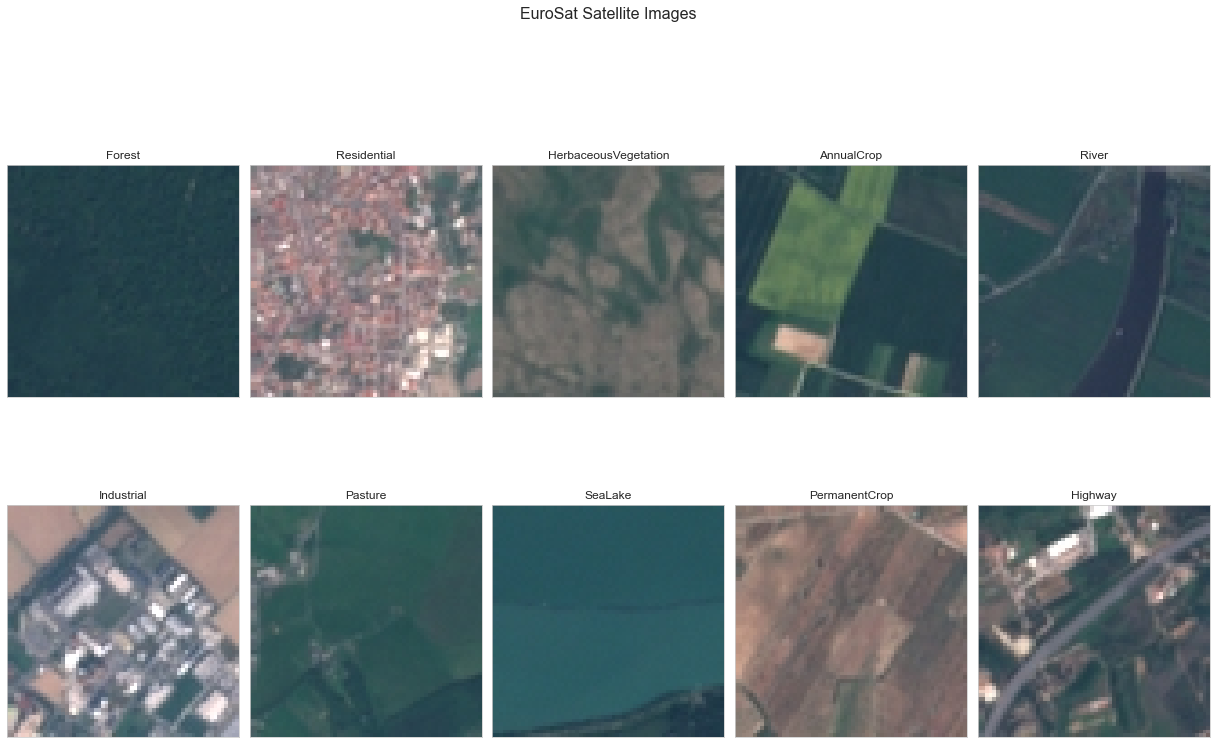

In [7]:
# Show sample images
fig, axes = plt.subplots(figsize=(17, 12), ncols=5, nrows=2)
axes = axes.flatten()
get_label_name = metadata.features['label'].int2str
labels = set()
c = 0
for img, label in raw_train.as_numpy_iterator():
    if label not in labels:
        axes[c].imshow(img)
        axes[c].set_title(get_label_name(label))
        axes[c].grid(False)
        axes[c].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False,
                            left=False, labelleft=False)
        labels.add(label)
        c += 1
        if c == 10:
            break
fig.suptitle('EuroSat Satellite Images', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.92);
# fig.savefig(results_path / 'eurosat_samples', dpi=300);

In [8]:
# Preprocessing
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 64, 64, 3])

In [9]:
# Load the DenseNet201 Bottleneck Features
densenet = DenseNet201(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', pooling='max',
                       classes=1000)

densenet.summary()

74850304/74836368 [==============================] - 7s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                       

In [10]:
feature_batch = densenet(image_batch)
feature_batch.shape

TensorShape([32, 1920])

In [11]:
len(densenet.layers)

708

In [12]:
# Add new layers to model
model = Sequential([
    densenet,
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

for layer in model.layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              3934208   
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8

In [13]:
# Compute baseline metrics
initial_epochs = 10
validation_steps = 20

initial_loss, initial_accuracy = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 9s 50ms/step - loss: 3255.9126 - accuracy: 0.1250


In [14]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 3255.91 | initial_accuracy accuracy: 12.50%


In [15]:
# Train model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
eurosat_path = (results_path / 'cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=eurosat_path, verbose=1, monitor='val_accuracy', save_best_only=True)
epochs = 100
history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches,
                    callbacks=[checkpointer, early_stopping], workers=6)

Epoch 1/100
675/675 [==============================] - ETA: 0s - loss: 789.9310 - accuracy: 0.8120
Epoch 00001: val_accuracy improved from -inf to 0.67074, saving model to results/eurosat\cnn.weights.best.hdf5
675/675 [==============================] - 134s 173ms/step - loss: 789.9310 - accuracy: 0.8120 - val_loss: 6.6478 - val_accuracy: 0.6707
Epoch 2/100
675/675 [==============================] - ETA: 0s - loss: 2.7839 - accuracy: 0.9145
Epoch 00002: val_accuracy improved from 0.67074 to 0.94741, saving model to results/eurosat\cnn.weights.best.hdf5
675/675 [==============================] - 116s 171ms/step - loss: 2.7839 - accuracy: 0.9145 - val_loss: 2.7190 - val_accuracy: 0.9474
Epoch 3/100
675/675 [==============================] - ETA: 0s - loss: 2.3447 - accuracy: 0.9541
Epoch 00003: val_accuracy did not improve from 0.94741
675/675 [==============================] - 111s 164ms/step - loss: 2.3447 - accuracy: 0.9541 - val_loss: 2.2897 - val_accuracy: 0.9370
Epoch 4/100
675/675 

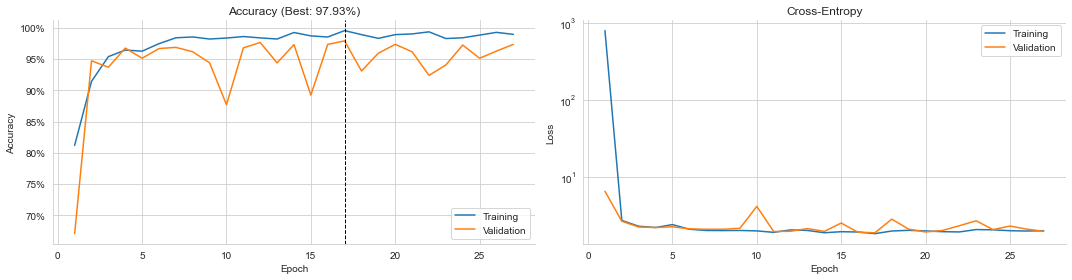

In [16]:
# Plot Learning Curves
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['accuracy', 'val_accuracy']].plot(ax=axes[0], title='Accuracy')
    df[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    fig.tight_layout()

metrics = pd.DataFrame(history.history)
metrics.index = metrics.index.to_series().add(1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics[['accuracy', 'val_accuracy']].plot(ax=axes[0],
                                           title=f'Accuracy (Best: {metrics.val_accuracy.max():.2%})')
axes[0].axvline(metrics.val_accuracy.idxmax(), ls='--', lw=1, c='k')
metrics[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy', logy=True)

for ax in axes:
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'satellite_accuracy', dpi=300);